# Load in data

In [59]:
import pandas as pd
import numpy as np

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, truncnorm, randint
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

In [60]:
# load in data, converters turns str dtype -> list
df = pd.read_csv('../data/train_cleaned.csv', converters={'cleaned': pd.eval}, index_col='Unnamed: 0')

# join lists as single string
df['words'] = df.cleaned.apply(lambda x: " ".join(x))
df.head(2)

,cleaned,class,words
0,"[catheterization, laboratory, event, hospital,...",4,catheterization laboratory event hospital outc...
1,"[renal, abscess, child, three, renal, abscess,...",5,renal abscess child three renal abscess child ...


In [61]:
df['class'] = df['class']-1

In [62]:
df = df.loc[df['class']<4]
df.head()

,cleaned,class,words
0,"[catheterization, laboratory, event, hospital,...",3,catheterization laboratory event hospital outc...
2,"[hyperplastic, polyp, see, sigmoidoscopy, mark...",1,hyperplastic polyp see sigmoidoscopy marker ad...
4,"[effect, local, inhibition, gamma, aminobutyri...",3,effect local inhibition gamma aminobutyric aci...
5,"[infection, chronic, epidural, catheterization...",0,infection chronic epidural catheterization dia...
8,"[multiple, representation, contribute, body, k...",2,multiple representation contribute body knowle...


In [38]:
df['class'].value_counts()

1    3163
4    3051
3    1925
2    1494
Name: class, dtype: int64

# fit_score function

In [39]:
def fit_score(estimator, vectorizer, dataframe=df, random_state=0, lsa=False, lsa_components=5):
    '''
    
    Prints the model type, vectorizer type, as well as train and test accuracy. 
    Also printsa classification report and plots a confusion matrix on the test data.
    
    Parameters:
    estimator - sklearn estimator
    vectorizer - sklearn word vectorizer
    dataframe - df containing cleaned dataset
    random_state - random state to be used
    lsa - whether or not to apply Latent Semantic Analysis to reduce dimensionality
    lsa_components - n_components hyperparameter for LSA
    
    Returns:
    estimator - fitted sklearn estimator
    
    '''
    
    # vectorize
    if lsa==True:
        svd=TruncatedSVD(n_components=lsa_components, random_state=0)
        X = svd.fit_transform(vectorizer.fit_transform(dataframe.words))
    else:
        X = vectorizer.fit_transform(dataframe.words)
            
    # target
    y = df['class']
    
    # 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # fit model
    estimator.fit(X_train, y_train)
    
    # training acc, testing acc
    train_acc, test_acc = estimator.score(X_train, y_train), estimator.score(X_test, y_test)
    
    print(f'Model: {estimator}')
    print(f'Vectorizer: {vectorizer}')
    print(f'Train accuracy: {train_acc*100:.1f}%')
    print(f'Test accuracy: {test_acc*100:.1f}%')
    
    print('\n\nClassification Report (Test Data):')
    print(classification_report(y_test, estimator.predict(X_test)))
    
    cm = ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
    cm.ax_.set_title('Conf Matrix on Test Data')
    

# Simple models

In [45]:
X = df['words']
y = df['class']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### MultinomialNB with CountVectorizer

Model: MultinomialNB()
Vectorizer: CountVectorizer()
Train accuracy: 70.8%
Test accuracy: 59.5%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.70      0.79      0.74       653
           2       0.53      0.70      0.60       294
           3       0.47      0.58      0.52       393
           4       0.65      0.76      0.70       585
           5       0.55      0.33      0.41       963

    accuracy                           0.59      2888
   macro avg       0.58      0.63      0.60      2888
weighted avg       0.59      0.59      0.58      2888



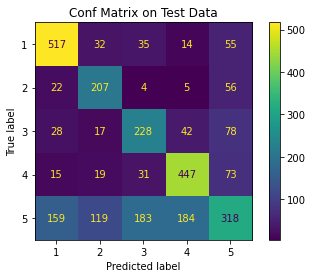

In [95]:
fit_score(MultinomialNB(), CountVectorizer())

Model: MultinomialNB()
Vectorizer: CountVectorizer(max_df=0.99, min_df=0.01)
Train accuracy: 58.9%
Test accuracy: 56.6%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.68      0.75      0.72       653
           2       0.47      0.69      0.56       294
           3       0.44      0.64      0.52       393
           4       0.67      0.69      0.68       585
           5       0.51      0.30      0.38       963

    accuracy                           0.57      2888
   macro avg       0.55      0.61      0.57      2888
weighted avg       0.57      0.57      0.55      2888



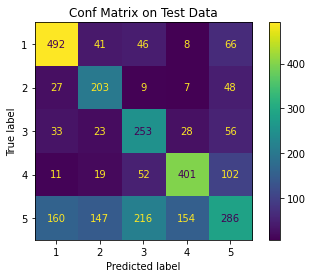

In [97]:
fit_score(MultinomialNB(), CountVectorizer(min_df=0.01, max_df=0.99))

In [102]:
nb_pipe = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=True)),
    ('classifier', MultinomialNB()),
])

In [103]:
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],  # Example: unigrams and bigrams
    'classifier__alpha': [0.1, 0.5, 1.0, 2.0],
    'classifier__fit_prior': [True, False],
}

In [104]:
grid_search = GridSearchCV(nb_pipe, param_grid, cv=5, scoring='accuracy')

In [105]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             param_grid={'classifier__alpha': [0.1, 0.5, 1.0, 2.0],
                         'classifier__fit_prior': [True, False],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                     (1, 4)]},
             scoring='accuracy')

In [106]:
grid_search.best_params_

{'classifier__alpha': 2.0,
 'classifier__fit_prior': False,
 'vectorizer__ngram_range': (1, 1)}

In [107]:
#grid_search.best_params_ = { 'classifier__alpha': 2.0,
#                             'classifier__fit_prior': False,
#                            'vectorizer__ngram_range': (1, 1)}

In [108]:
grid_search.best_estimator_

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB(alpha=2.0, fit_prior=False))])

In [109]:
grid_search.best_score_

0.585974025974026

In [110]:
grid_search.score(X_train,y_train)

0.6995670995670996

In [111]:
grid_search.score(X_test,y_test)

0.603185595567867

Text(0.5, 1.0, 'Conf Matrix on Test Data')

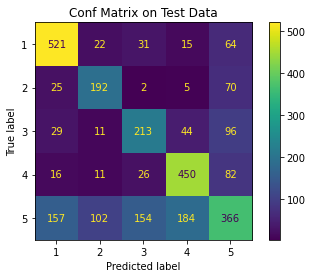

In [112]:
cm = ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test)
cm.ax_.set_title('Conf Matrix on Test Data')

### DecisionTree with CountVectorizer

Model: DecisionTreeClassifier()
Vectorizer: CountVectorizer()
Train accuracy: 82.1%
Test accuracy: 44.2%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.59      0.61      0.60       653
           2       0.34      0.36      0.35       294
           3       0.33      0.33      0.33       393
           4       0.54      0.56      0.55       585
           5       0.35      0.33      0.34       963

    accuracy                           0.44      2888
   macro avg       0.43      0.44      0.43      2888
weighted avg       0.44      0.44      0.44      2888



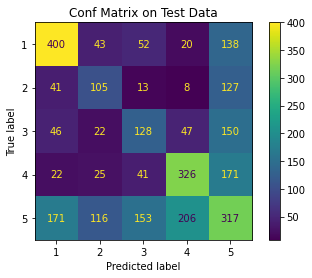

In [34]:
fit_score(DecisionTreeClassifier(), CountVectorizer())

Model: DecisionTreeClassifier(max_depth=25)
Vectorizer: CountVectorizer()
Train accuracy: 66.3%
Test accuracy: 48.2%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.66      0.58      0.62       653
           2       0.40      0.31      0.35       294
           3       0.30      0.12      0.18       393
           4       0.59      0.52      0.55       585
           5       0.40      0.59      0.48       963

    accuracy                           0.48      2888
   macro avg       0.47      0.43      0.43      2888
weighted avg       0.48      0.48      0.47      2888



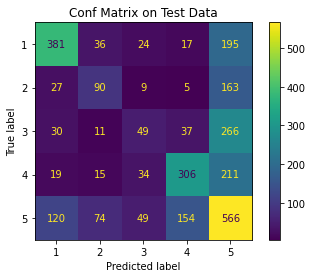

In [91]:
fit_score(DecisionTreeClassifier(max_depth=25), CountVectorizer())

### RandomForest with CountVectorizer

Model: RandomForestClassifier(n_estimators=10)
Vectorizer: CountVectorizer()
Train accuracy: 81.7%
Test accuracy: 43.5%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.61      0.62      0.62       653
           2       0.30      0.22      0.25       294
           3       0.30      0.21      0.25       393
           4       0.52      0.55      0.53       585
           5       0.34      0.40      0.37       963

    accuracy                           0.44      2888
   macro avg       0.42      0.40      0.40      2888
weighted avg       0.43      0.44      0.43      2888



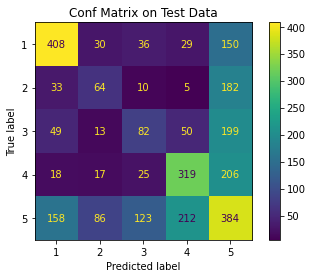

In [4]:
fit_score(RandomForestClassifier(n_estimators =10), CountVectorizer())

Model: RandomForestClassifier(n_estimators=40)
Vectorizer: CountVectorizer()
Train accuracy: 82.1%
Test accuracy: 46.1%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.65      0.65      0.65       653
           2       0.34      0.24      0.28       294
           3       0.35      0.24      0.28       393
           4       0.54      0.58      0.56       585
           5       0.36      0.42      0.39       963

    accuracy                           0.46      2888
   macro avg       0.45      0.42      0.43      2888
weighted avg       0.46      0.46      0.46      2888



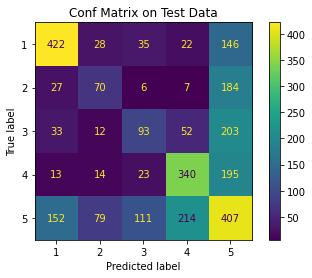

In [5]:
fit_score(RandomForestClassifier(n_estimators =40), CountVectorizer())

In [81]:
rf_pipe = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=True)),
    ('rf',RandomForestClassifier())
])

In [82]:
model_params = {
    'rf__n_estimators': randint(4,100),
    'rf__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'rf__min_samples_split': uniform(0.01, 0.199)
    'rf__max_dept':
}

In [83]:
rgs=RandomizedSearchCV(rf_pipe,
                       model_params,
                       random_state=42,
                       verbose=1,
                       n_iter=50,
                       n_jobs=-1)

In [84]:
rgs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.28261572]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.28261572]) instead.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.303695]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.25856456]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.25856456]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.3089322]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.3089322]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.32862857]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.32862857]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.34890727]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.34890727]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.29652474]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.29652474]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.29652648]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.29652648]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.34636382]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.34636382]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.32323276]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.32323276]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.34766174]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.34766174]) instead.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.31195392]) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.31195392]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.34303192]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.34303192]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.25136615]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.25136615]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.28859786]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.28859786]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.25294279]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.25294279]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.26565629]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.26565629]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.26788692]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.26788692]) instead.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.34579762]) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.34579762]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.28448128]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.28448128]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.33952637]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.33952637]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.29615112]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.29615112]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.28389411]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.28389411]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.30252187]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.30252187]) instead.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.29824207]) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.29824207]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.2641881]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.2641881]) instead.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.32179362]) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.32179362]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.25120473]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.25120473]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.31708526]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.31708526]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.34009327]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.34009327]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.33225422]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.33225422]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.25817261]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.25817261]) instead.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.27819253]) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.27819253]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.33518287]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.33518287]) instead.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.31540567]) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.31540567]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.27033064]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.27033064]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.29633189]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.29633189]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.28852265]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.28852265]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.30746481]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.30746481]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.31353833]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.31353833]) instead.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.31995743]) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.31995743]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.30371546]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.30371546]) instead.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.34053024]) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.34053024]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.25903864]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.25903864]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.28642745]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.28642745]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.28097393]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.28097393]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.26962799]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.26962799]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.3319698]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.3319698]) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.29741643]) instead.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.29741643]) instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got array([0.27325961]) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got array([0.27325961]) instead.


### Adaboost with CountVectorizer

Model: AdaBoostClassifier()
Vectorizer: CountVectorizer()
Train accuracy: 58.2%
Test accuracy: 57.4%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.72      0.75      0.73       653
           2       0.56      0.40      0.47       294
           3       0.49      0.28      0.36       393
           4       0.67      0.68      0.67       585
           5       0.46      0.56      0.51       963

    accuracy                           0.57      2888
   macro avg       0.58      0.54      0.55      2888
weighted avg       0.58      0.57      0.57      2888



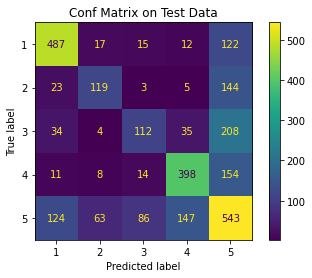

In [9]:
fit_score(AdaBoostClassifier(), CountVectorizer())

Model: AdaBoostClassifier()
Vectorizer: CountVectorizer()
Train accuracy: 78.1%
Test accuracy: 76.2%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.82      0.79      0.81       638
           2       0.78      0.66      0.71       304
           3       0.56      0.68      0.62       382
           4       0.86      0.83      0.84       603

    accuracy                           0.76      1927
   macro avg       0.75      0.74      0.74      1927
weighted avg       0.77      0.76      0.77      1927



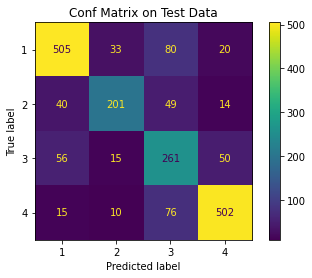

In [21]:
fit_score(AdaBoostClassifier(), CountVectorizer())

Model: AdaBoostClassifier()
Vectorizer: TfidfVectorizer()
Train accuracy: 78.0%
Test accuracy: 75.7%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.84      0.75      0.79       638
           2       0.78      0.66      0.71       304
           3       0.54      0.71      0.61       382
           4       0.85      0.84      0.85       603

    accuracy                           0.76      1927
   macro avg       0.75      0.74      0.74      1927
weighted avg       0.77      0.76      0.76      1927



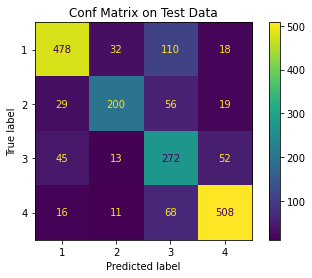

In [22]:
fit_score(AdaBoostClassifier(), TfidfVectorizer())

Model: AdaBoostClassifier()
Vectorizer: TfidfVectorizer()
Train accuracy: 69.9%
Test accuracy: 68.6%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.75      0.83      0.79       638
           2       0.48      0.38      0.42       304
           3       0.50      0.50      0.50       382
           4       0.81      0.81      0.81       603

    accuracy                           0.69      1927
   macro avg       0.63      0.63      0.63      1927
weighted avg       0.68      0.69      0.68      1927



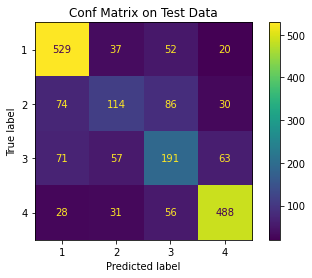

In [23]:
fit_score(AdaBoostClassifier(), TfidfVectorizer(), lsa = True)

Model: AdaBoostClassifier()
Vectorizer: CountVectorizer(max_df=0.99, min_df=0.01)
Train accuracy: 57.8%
Test accuracy: 57.1%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.73      0.72       653
           2       0.56      0.38      0.45       294
           3       0.46      0.34      0.39       393
           4       0.66      0.70      0.68       585
           5       0.47      0.54      0.50       963

    accuracy                           0.57      2888
   macro avg       0.57      0.54      0.55      2888
weighted avg       0.57      0.57      0.57      2888



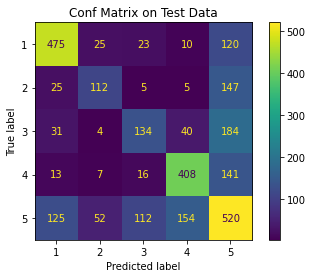

In [146]:
fit_score(AdaBoostClassifier(), CountVectorizer(min_df=0.01,max_df=0.99))

Model: AdaBoostClassifier()
Vectorizer: CountVectorizer(max_df=0.99, max_features=1500, min_df=0.01)
Train accuracy: 57.8%
Test accuracy: 57.1%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.73      0.72       653
           2       0.56      0.38      0.45       294
           3       0.46      0.34      0.39       393
           4       0.66      0.70      0.68       585
           5       0.47      0.54      0.50       963

    accuracy                           0.57      2888
   macro avg       0.57      0.54      0.55      2888
weighted avg       0.57      0.57      0.57      2888



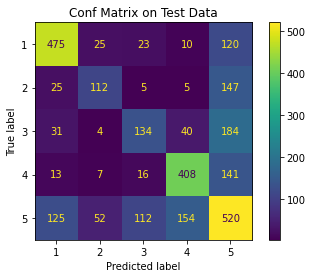

In [147]:
fit_score(AdaBoostClassifier(), CountVectorizer(min_df=0.01,max_df=0.99,max_features=1500))

Model: AdaBoostClassifier()
Vectorizer: CountVectorizer(max_df=0.99, max_features=1000, min_df=0.01)
Train accuracy: 57.5%
Test accuracy: 57.2%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.72      0.72       653
           2       0.56      0.38      0.45       294
           3       0.47      0.34      0.39       393
           4       0.66      0.69      0.68       585
           5       0.47      0.56      0.51       963

    accuracy                           0.57      2888
   macro avg       0.57      0.54      0.55      2888
weighted avg       0.57      0.57      0.57      2888



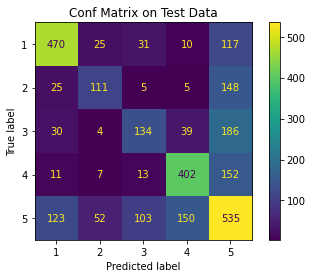

In [148]:
fit_score(AdaBoostClassifier(), CountVectorizer(min_df=0.01,max_df=0.99,max_features=1000))

Model: AdaBoostClassifier()
Vectorizer: CountVectorizer(max_features=1000)
Train accuracy: 58.9%
Test accuracy: 58.3%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.72      0.71       653
           2       0.56      0.45      0.50       294
           3       0.50      0.43      0.46       393
           4       0.67      0.70      0.69       585
           5       0.48      0.52      0.50       963

    accuracy                           0.58      2888
   macro avg       0.58      0.56      0.57      2888
weighted avg       0.58      0.58      0.58      2888



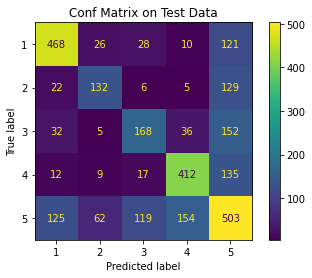

In [149]:
fit_score(AdaBoostClassifier(), CountVectorizer(max_features=1000))

Model: AdaBoostClassifier()
Vectorizer: CountVectorizer(max_df=0.99, max_features=1000)
Train accuracy: 58.9%
Test accuracy: 58.3%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.72      0.71       653
           2       0.56      0.45      0.50       294
           3       0.50      0.43      0.46       393
           4       0.67      0.70      0.69       585
           5       0.48      0.52      0.50       963

    accuracy                           0.58      2888
   macro avg       0.58      0.56      0.57      2888
weighted avg       0.58      0.58      0.58      2888



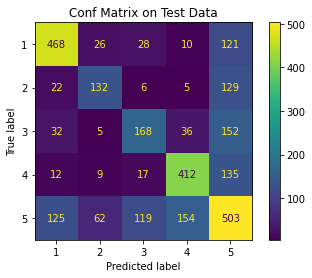

In [152]:
fit_score(AdaBoostClassifier(), CountVectorizer(max_df=0.99,max_features=1000))

Model: AdaBoostClassifier()
Vectorizer: CountVectorizer(max_df=0.95, max_features=1000)
Train accuracy: 58.9%
Test accuracy: 58.3%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.72      0.71       653
           2       0.56      0.45      0.50       294
           3       0.50      0.43      0.46       393
           4       0.67      0.70      0.69       585
           5       0.48      0.52      0.50       963

    accuracy                           0.58      2888
   macro avg       0.58      0.56      0.57      2888
weighted avg       0.58      0.58      0.58      2888



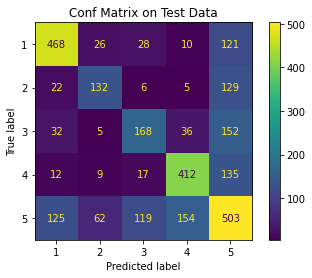

In [153]:
fit_score(AdaBoostClassifier(), CountVectorizer(max_df=0.95,max_features=1000))

### Adaboost with TfidfVectorizer

Model: AdaBoostClassifier()
Vectorizer: TfidfVectorizer()
Train accuracy: 57.4%
Test accuracy: 55.9%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.72      0.67      0.69       653
           2       0.56      0.40      0.47       294
           3       0.42      0.25      0.31       393
           4       0.67      0.68      0.68       585
           5       0.45      0.58      0.51       963

    accuracy                           0.56      2888
   macro avg       0.56      0.52      0.53      2888
weighted avg       0.56      0.56      0.55      2888



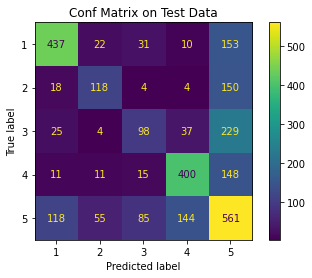

In [154]:
fit_score(AdaBoostClassifier(), TfidfVectorizer())

Model: AdaBoostClassifier()
Vectorizer: CountVectorizer()
Train accuracy: 51.5%
Test accuracy: 51.1%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.70      0.65      0.68       653
           2       0.25      0.00      0.01       294
           3       0.00      0.00      0.00       393
           4       0.60      0.62      0.61       585
           5       0.41      0.71      0.52       963

    accuracy                           0.51      2888
   macro avg       0.39      0.40      0.36      2888
weighted avg       0.44      0.51      0.45      2888



C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


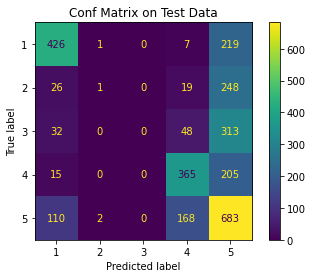

In [10]:
fit_score(AdaBoostClassifier(), CountVectorizer(),lsa =True)

Model: AdaBoostClassifier()
Vectorizer: TfidfVectorizer()
Train accuracy: 53.4%
Test accuracy: 53.1%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.68      0.74      0.71       653
           2       0.49      0.07      0.12       294
           3       0.36      0.05      0.08       393
           4       0.63      0.69      0.66       585
           5       0.42      0.63      0.50       963

    accuracy                           0.53      2888
   macro avg       0.52      0.44      0.42      2888
weighted avg       0.52      0.53      0.49      2888



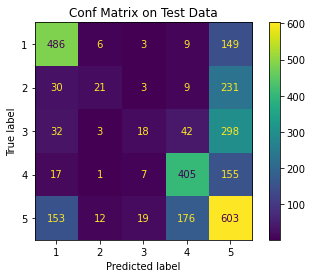

In [14]:
fit_score(AdaBoostClassifier(), TfidfVectorizer(),lsa =True)

Model: AdaBoostClassifier()
Vectorizer: TfidfVectorizer(max_df=0.99, min_df=0.01)
Train accuracy: 57.7%
Test accuracy: 57.3%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.72      0.69      0.71       653
           2       0.54      0.39      0.45       294
           3       0.49      0.36      0.41       393
           4       0.66      0.70      0.68       585
           5       0.47      0.56      0.51       963

    accuracy                           0.57      2888
   macro avg       0.58      0.54      0.55      2888
weighted avg       0.58      0.57      0.57      2888



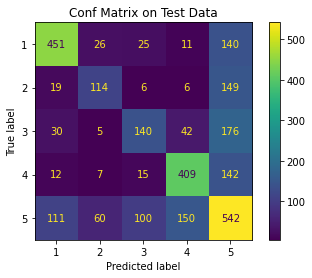

In [155]:
fit_score(AdaBoostClassifier(), TfidfVectorizer(min_df=0.01,max_df=0.99))

Model: AdaBoostClassifier()
Vectorizer: TfidfVectorizer(max_df=0.99, max_features=1500, min_df=0.01)
Train accuracy: 57.7%
Test accuracy: 57.3%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.72      0.69      0.71       653
           2       0.54      0.39      0.45       294
           3       0.49      0.36      0.41       393
           4       0.66      0.70      0.68       585
           5       0.47      0.56      0.51       963

    accuracy                           0.57      2888
   macro avg       0.58      0.54      0.55      2888
weighted avg       0.58      0.57      0.57      2888



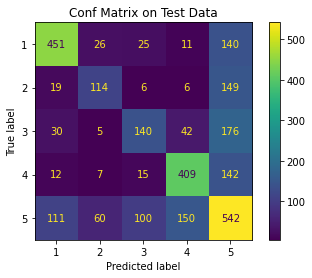

In [156]:
fit_score(AdaBoostClassifier(), TfidfVectorizer(min_df=0.01,max_df=0.99,max_features=1500))

Model: AdaBoostClassifier()
Vectorizer: TfidfVectorizer(max_df=0.99, max_features=500, min_df=0.01)
Train accuracy: 57.6%
Test accuracy: 56.5%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.70      0.69      0.70       653
           2       0.53      0.42      0.47       294
           3       0.47      0.36      0.41       393
           4       0.65      0.73      0.68       585
           5       0.46      0.51      0.49       963

    accuracy                           0.56      2888
   macro avg       0.56      0.54      0.55      2888
weighted avg       0.56      0.56      0.56      2888



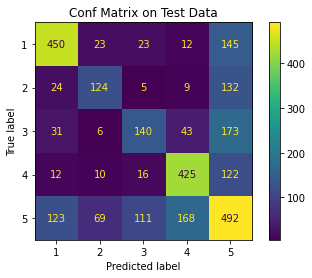

In [158]:
fit_score(AdaBoostClassifier(), TfidfVectorizer(min_df=0.01,max_df=0.99,max_features=500))

Model: AdaBoostClassifier()
Vectorizer: TfidfVectorizer(max_df=0.99, max_features=1000, min_df=0.01)
Train accuracy: 57.7%
Test accuracy: 57.2%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.72      0.69      0.70       653
           2       0.55      0.39      0.45       294
           3       0.47      0.34      0.40       393
           4       0.67      0.72      0.69       585
           5       0.47      0.55      0.51       963

    accuracy                           0.57      2888
   macro avg       0.57      0.54      0.55      2888
weighted avg       0.57      0.57      0.57      2888



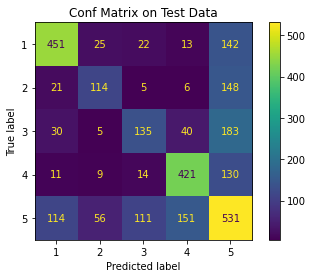

In [159]:
fit_score(AdaBoostClassifier(), TfidfVectorizer(min_df=0.01,max_df=0.99,max_features=1000))

Model: AdaBoostClassifier()
Vectorizer: TfidfVectorizer(max_df=0.95, max_features=1000)
Train accuracy: 58.2%
Test accuracy: 56.9%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.68      0.69       653
           2       0.59      0.41      0.48       294
           3       0.45      0.33      0.38       393
           4       0.66      0.70      0.68       585
           5       0.47      0.56      0.51       963

    accuracy                           0.57      2888
   macro avg       0.58      0.54      0.55      2888
weighted avg       0.57      0.57      0.57      2888



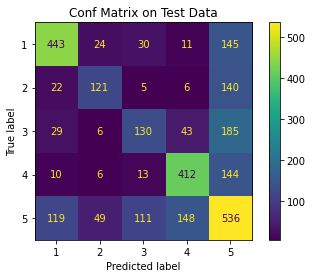

In [161]:
fit_score(AdaBoostClassifier(), TfidfVectorizer(max_df=0.95,max_features=1000))

### Gradientboost with CountVectorizer

Model: GradientBoostingClassifier()
Vectorizer: CountVectorizer()
Train accuracy: 66.2%
Test accuracy: 57.2%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.72      0.72       653
           2       0.54      0.36      0.43       294
           3       0.53      0.33      0.40       393
           4       0.68      0.63      0.65       585
           5       0.46      0.60      0.52       963

    accuracy                           0.57      2888
   macro avg       0.59      0.53      0.55      2888
weighted avg       0.58      0.57      0.57      2888



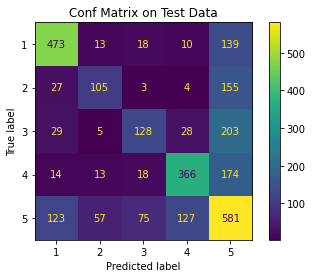

In [125]:
fit_score(GradientBoostingClassifier(), CountVectorizer())

Model: GradientBoostingClassifier()
Vectorizer: CountVectorizer()
Train accuracy: 55.3%
Test accuracy: 50.9%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.69      0.70      0.69       653
           2       0.22      0.02      0.03       294
           3       0.17      0.01      0.02       393
           4       0.61      0.65      0.63       585
           5       0.40      0.65      0.50       963

    accuracy                           0.51      2888
   macro avg       0.42      0.40      0.37      2888
weighted avg       0.46      0.51      0.46      2888



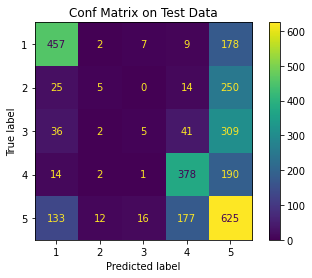

In [9]:
fit_score(GradientBoostingClassifier(), CountVectorizer(),lsa =True)

Model: GradientBoostingClassifier()
Vectorizer: TfidfVectorizer()
Train accuracy: 57.5%
Test accuracy: 51.7%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.68      0.74      0.71       653
           2       0.31      0.06      0.11       294
           3       0.29      0.10      0.15       393
           4       0.62      0.72      0.66       585
           5       0.41      0.55      0.47       963

    accuracy                           0.52      2888
   macro avg       0.46      0.44      0.42      2888
weighted avg       0.49      0.52      0.48      2888



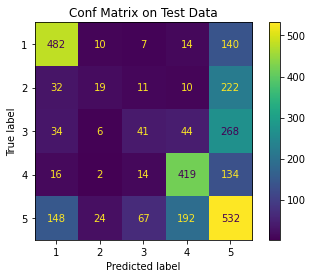

In [13]:
fit_score(GradientBoostingClassifier(), TfidfVectorizer(),lsa =True)

Model: GradientBoostingClassifier()
Vectorizer: CountVectorizer()
Train accuracy: 86.3%
Test accuracy: 80.6%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.83      0.83      0.83       638
           2       0.83      0.73      0.78       304
           3       0.66      0.73      0.69       382
           4       0.87      0.86      0.87       603

    accuracy                           0.81      1927
   macro avg       0.80      0.79      0.79      1927
weighted avg       0.81      0.81      0.81      1927



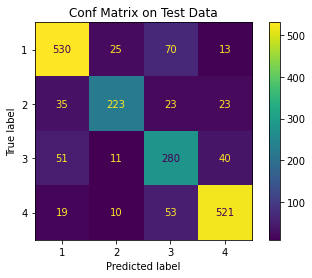

In [24]:
fit_score(GradientBoostingClassifier(), CountVectorizer())

Model: LogisticRegression(n_jobs=-1)
Vectorizer: TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
Train accuracy: 82.6%
Test accuracy: 81.3%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.82      0.85      0.83       638
           2       0.82      0.72      0.76       304
           3       0.73      0.73      0.73       382
           4       0.86      0.88      0.87       603

    accuracy                           0.81      1927
   macro avg       0.81      0.79      0.80      1927
weighted avg       0.81      0.81      0.81      1927



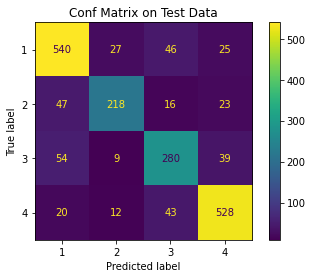

In [11]:
fit_score(LogisticRegression(max_iter=100, n_jobs=-1), TfidfVectorizer(max_features=10000, ngram_range=(1,2)),\
          lsa=True, lsa_components=100)

In [46]:
logit_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('gb',LogisticRegression())
])

In [47]:
logit_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer()), ('gb', LogisticRegression())],
 'verbose': False,
 'vectorizer': TfidfVectorizer(),
 'gb': LogisticRegression(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabulary': None,
 'gb__C': 1.0,
 'gb__class_weight': None,
 'gb__dual': False,
 'gb__fit_intercept': True,
 'gb__intercept_scaling':

In [51]:
params ={
    'vectorizer__max_features': [1000,5000,10000],
    'vectorizer__ngram_range': [(1, 1),(1,2),(1,3)],
    'gb__max_iter': [10,100,500]
}


In [52]:
logit = GridSearchCV(
    estimator=logit_pipe,
    param_grid=params,
    cv=5,
    verbose=1
)


In [53]:
logit.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('gb', LogisticRegression())]),
             param_grid={'gb__max_iter': [10, 100, 500],
                         'vectorizer__max_features': [1000, 5000, 10000],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [54]:
logit.best_score_

0.8220870777225361

In [55]:
logit.score(X_train,y_train)

0.8983908642616143

In [56]:
logit.score(X_test,y_test)

0.8147379346133887

In [57]:
logit.best_estimator_

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('gb', LogisticRegression())])

In [58]:
logit.best_params_

{'gb__max_iter': 100,
 'vectorizer__max_features': 10000,
 'vectorizer__ngram_range': (1, 3)}

In [ ]:
#logit.best_params_={'gb__max_iter': 100,
#                     'vectorizer__max_features': 10000,
#                     'vectorizer__ngram_range': (1, 3)}

Model: GradientBoostingClassifier()
Vectorizer: CountVectorizer(max_df=0.95)
Train accuracy: 83.7%
Test accuracy: 73.8%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.77      0.81      0.79       638
           2       0.68      0.57      0.62       304
           3       0.61      0.63      0.62       382
           4       0.81      0.82      0.82       603

    accuracy                           0.74      1927
   macro avg       0.72      0.71      0.71      1927
weighted avg       0.74      0.74      0.74      1927



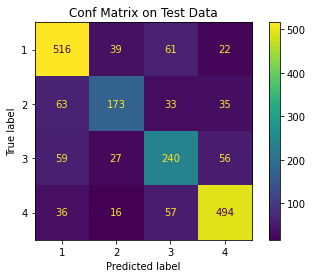

In [7]:
fit_score(GradientBoostingClassifier(), CountVectorizer(), lsa=True, lsa_components=1000)

Model: GradientBoostingClassifier()
Vectorizer: TfidfVectorizer()
Train accuracy: 86.8%
Test accuracy: 80.3%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.83      0.83      0.83       638
           2       0.83      0.72      0.77       304
           3       0.65      0.73      0.69       382
           4       0.87      0.86      0.87       603

    accuracy                           0.80      1927
   macro avg       0.80      0.79      0.79      1927
weighted avg       0.81      0.80      0.80      1927



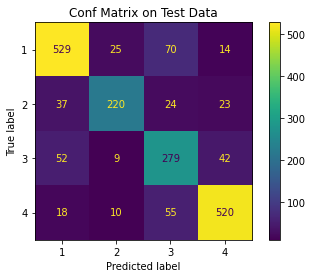

In [25]:
fit_score(GradientBoostingClassifier(), TfidfVectorizer())

Model: GradientBoostingClassifier()
Vectorizer: CountVectorizer(max_df=0.99, min_df=0.01)
Train accuracy: 64.9%
Test accuracy: 57.4%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.74      0.72       653
           2       0.54      0.39      0.46       294
           3       0.52      0.33      0.41       393
           4       0.69      0.62      0.65       585
           5       0.46      0.58      0.52       963

    accuracy                           0.57      2888
   macro avg       0.59      0.54      0.55      2888
weighted avg       0.58      0.57      0.57      2888



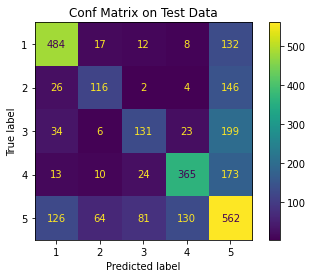

In [98]:
fit_score(GradientBoostingClassifier(), CountVectorizer(min_df=0.01, max_df=0.99))

Model: GradientBoostingClassifier()
Vectorizer: CountVectorizer(max_df=0.99, max_features=1500, min_df=0.01)
Train accuracy: 64.9%
Test accuracy: 56.8%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.74      0.73       653
           2       0.54      0.39      0.45       294
           3       0.51      0.32      0.39       393
           4       0.68      0.61      0.64       585
           5       0.46      0.58      0.51       963

    accuracy                           0.57      2888
   macro avg       0.58      0.53      0.54      2888
weighted avg       0.58      0.57      0.56      2888



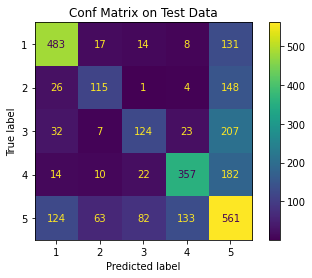

In [128]:
fit_score(GradientBoostingClassifier(), CountVectorizer(min_df=0.01, max_df=0.99,max_features=1500))

Model: GradientBoostingClassifier()
Vectorizer: CountVectorizer(max_df=0.99, max_features=1000, min_df=0.01)
Train accuracy: 65.1%
Test accuracy: 57.5%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.74      0.72       653
           2       0.55      0.40      0.46       294
           3       0.51      0.32      0.39       393
           4       0.69      0.64      0.66       585
           5       0.47      0.58      0.52       963

    accuracy                           0.57      2888
   macro avg       0.58      0.54      0.55      2888
weighted avg       0.58      0.57      0.57      2888



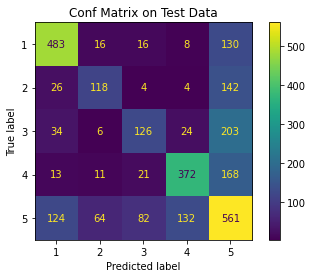

In [129]:
fit_score(GradientBoostingClassifier(), CountVectorizer(min_df=0.01, max_df=0.99,max_features=1000))#best of Gradientboost

Model: GradientBoostingClassifier()
Vectorizer: CountVectorizer(max_features=1000)
Train accuracy: 65.4%
Test accuracy: 56.5%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.73      0.72       653
           2       0.52      0.37      0.43       294
           3       0.51      0.32      0.39       393
           4       0.68      0.61      0.64       585
           5       0.46      0.58      0.51       963

    accuracy                           0.56      2888
   macro avg       0.57      0.52      0.54      2888
weighted avg       0.57      0.56      0.56      2888



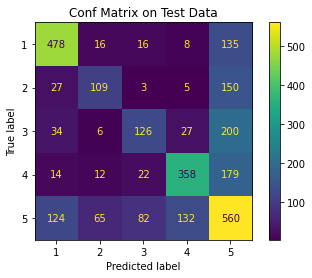

In [131]:
fit_score(GradientBoostingClassifier(), CountVectorizer(max_features=1000))

Model: GradientBoostingClassifier()
Vectorizer: CountVectorizer(max_df=0.99, max_features=1000)
Train accuracy: 65.3%
Test accuracy: 57.1%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.73      0.72       653
           2       0.53      0.39      0.45       294
           3       0.52      0.33      0.41       393
           4       0.68      0.63      0.65       585
           5       0.46      0.58      0.51       963

    accuracy                           0.57      2888
   macro avg       0.58      0.53      0.55      2888
weighted avg       0.58      0.57      0.57      2888



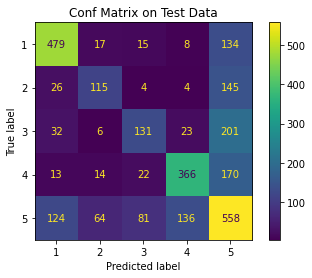

In [132]:
fit_score(GradientBoostingClassifier(), CountVectorizer(max_df=0.99,max_features=1000))

Model: GradientBoostingClassifier(max_depth=2)
Vectorizer: CountVectorizer(max_df=0.95, max_features=1000)
Train accuracy: 61.1%
Test accuracy: 57.7%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.72      0.73      0.73       653
           2       0.58      0.36      0.44       294
           3       0.56      0.30      0.39       393
           4       0.70      0.60      0.65       585
           5       0.46      0.64      0.53       963

    accuracy                           0.58      2888
   macro avg       0.60      0.53      0.55      2888
weighted avg       0.59      0.58      0.57      2888



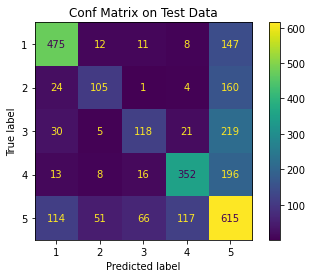

In [135]:
fit_score(GradientBoostingClassifier(max_depth=2), CountVectorizer(max_df=0.95,max_features=1000))

Model: GradientBoostingClassifier(max_depth=2, min_samples_split=5)
Vectorizer: CountVectorizer(max_df=0.95, max_features=1000)
Train accuracy: 61.1%
Test accuracy: 57.7%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.72      0.73      0.73       653
           2       0.58      0.36      0.44       294
           3       0.56      0.30      0.39       393
           4       0.70      0.60      0.65       585
           5       0.46      0.64      0.53       963

    accuracy                           0.58      2888
   macro avg       0.60      0.53      0.55      2888
weighted avg       0.59      0.58      0.57      2888



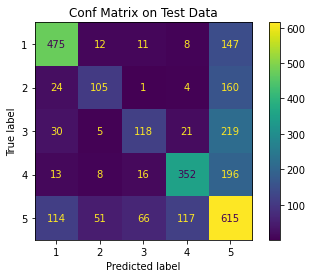

In [136]:
fit_score(GradientBoostingClassifier(max_depth=2,min_samples_split=5), CountVectorizer(max_df=0.95,max_features=1000))

Model: GradientBoostingClassifier()
Vectorizer: CountVectorizer(max_df=0.95, max_features=1000)
Train accuracy: 65.3%
Test accuracy: 57.2%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.73      0.72       653
           2       0.54      0.39      0.46       294
           3       0.52      0.33      0.40       393
           4       0.68      0.62      0.65       585
           5       0.47      0.58      0.52       963

    accuracy                           0.57      2888
   macro avg       0.58      0.53      0.55      2888
weighted avg       0.58      0.57      0.57      2888



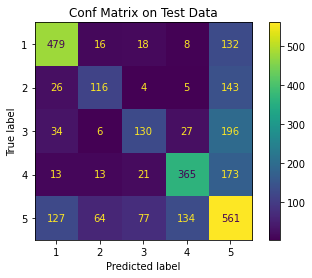

In [137]:
fit_score(GradientBoostingClassifier(), CountVectorizer(max_df=0.95,max_features=1000))

Model: GradientBoostingClassifier()
Vectorizer: TfidfVectorizer(max_df=0.99, max_features=1500, min_df=0.01)
Train accuracy: 66.1%
Test accuracy: 56.5%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.70      0.72      0.71       653
           2       0.53      0.37      0.43       294
           3       0.49      0.31      0.38       393
           4       0.69      0.63      0.66       585
           5       0.46      0.58      0.51       963

    accuracy                           0.57      2888
   macro avg       0.57      0.52      0.54      2888
weighted avg       0.57      0.57      0.56      2888



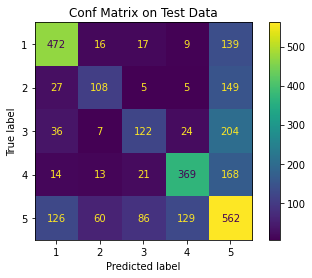

In [139]:
fit_score(GradientBoostingClassifier(), TfidfVectorizer(min_df=0.01, max_df=0.99,max_features=1500))

Model: GradientBoostingClassifier()
Vectorizer: TfidfVectorizer(max_df=0.99, max_features=1000, min_df=0.01)
Train accuracy: 66.5%
Test accuracy: 56.3%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.70      0.72      0.71       653
           2       0.52      0.36      0.43       294
           3       0.50      0.32      0.39       393
           4       0.68      0.63      0.65       585
           5       0.45      0.58      0.51       963

    accuracy                           0.56      2888
   macro avg       0.57      0.52      0.54      2888
weighted avg       0.57      0.56      0.56      2888



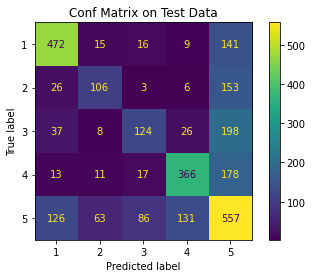

In [140]:
fit_score(GradientBoostingClassifier(), TfidfVectorizer(min_df=0.01, max_df=0.99,max_features=1000))

Model: GradientBoostingClassifier()
Vectorizer: TfidfVectorizer(max_df=0.99, max_features=5000, min_df=0.01)
Train accuracy: 66.1%
Test accuracy: 56.5%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.70      0.72      0.71       653
           2       0.53      0.36      0.43       294
           3       0.48      0.31      0.38       393
           4       0.69      0.63      0.66       585
           5       0.46      0.58      0.51       963

    accuracy                           0.56      2888
   macro avg       0.57      0.52      0.54      2888
weighted avg       0.57      0.56      0.56      2888



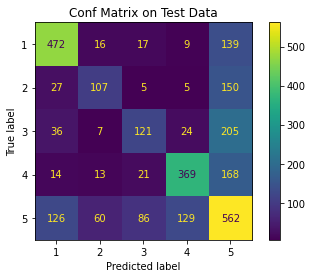

In [141]:
fit_score(GradientBoostingClassifier(), TfidfVectorizer(min_df=0.01, max_df=0.99,max_features=5000))

Model: GradientBoostingClassifier()
Vectorizer: TfidfVectorizer(max_features=1000)
Train accuracy: 66.6%
Test accuracy: 56.4%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.70      0.72      0.71       653
           2       0.51      0.37      0.43       294
           3       0.51      0.33      0.40       393
           4       0.68      0.63      0.66       585
           5       0.46      0.57      0.51       963

    accuracy                           0.56      2888
   macro avg       0.57      0.52      0.54      2888
weighted avg       0.57      0.56      0.56      2888



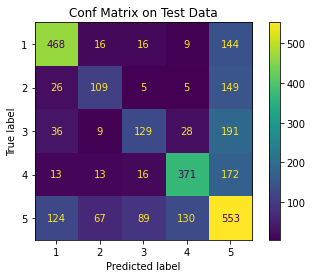

In [143]:
fit_score(GradientBoostingClassifier(), TfidfVectorizer(max_features=1000))

Model: GradientBoostingClassifier()
Vectorizer: TfidfVectorizer(max_df=0.95, max_features=5000)
Train accuracy: 67.5%
Test accuracy: 56.8%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.72      0.71       653
           2       0.52      0.35      0.42       294
           3       0.54      0.31      0.40       393
           4       0.68      0.63      0.65       585
           5       0.46      0.60      0.52       963

    accuracy                           0.57      2888
   macro avg       0.58      0.52      0.54      2888
weighted avg       0.58      0.57      0.56      2888



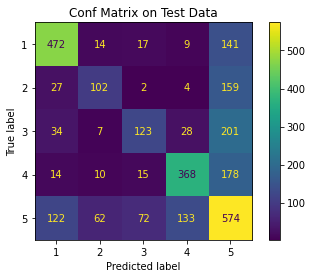

In [142]:
fit_score(GradientBoostingClassifier(), TfidfVectorizer(max_df=0.95,max_features=5000))

Model: GradientBoostingClassifier(max_depth=2)
Vectorizer: TfidfVectorizer(max_df=0.95, max_features=1000)
Train accuracy: 62.3%
Test accuracy: 57.8%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.72      0.72       653
           2       0.58      0.37      0.46       294
           3       0.54      0.32      0.40       393
           4       0.70      0.62      0.66       585
           5       0.47      0.63      0.54       963

    accuracy                           0.58      2888
   macro avg       0.60      0.53      0.55      2888
weighted avg       0.59      0.58      0.57      2888



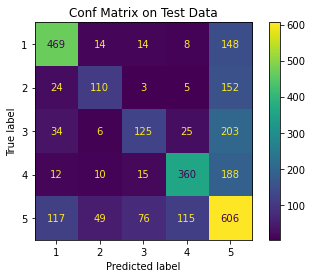

In [144]:
fit_score(GradientBoostingClassifier(max_depth=2), TfidfVectorizer(max_df=0.95,max_features=1000))

Model: GradientBoostingClassifier(max_depth=2, min_samples_split=5)
Vectorizer: TfidfVectorizer(max_df=0.95, max_features=1000)
Train accuracy: 62.3%
Test accuracy: 57.8%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.71      0.72      0.72       653
           2       0.58      0.37      0.46       294
           3       0.54      0.32      0.40       393
           4       0.70      0.62      0.66       585
           5       0.47      0.63      0.54       963

    accuracy                           0.58      2888
   macro avg       0.60      0.53      0.55      2888
weighted avg       0.59      0.58      0.57      2888



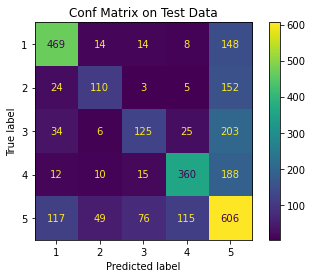

In [145]:
fit_score(GradientBoostingClassifier(max_depth=2, min_samples_split=5), TfidfVectorizer(max_df=0.95,max_features=1000))

In [182]:
GB_pipe = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=True)),
    ('gb',GradientBoostingClassifier())
])

In [183]:
GB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'gb', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__preprocessor', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__vocabulary', 'gb__ccp_alpha', 'gb__criterion', 'gb__init', 'gb__learning_rate', 'gb__loss', 'gb__max_depth', 'gb__max_features', 'gb__max_leaf_nodes', 'gb__min_impurity_decrease', 'gb__min_samples_leaf', 'gb__min_samples_split', 'gb__min_weight_fraction_leaf', 'gb__n_estimators', 'gb__n_iter_no_change', 'gb__random_state', 'gb__subsample', 'gb__tol', 'gb__validation_fraction', 'gb__verbose', 'gb__warm_start'])

In [184]:
model_params = {
    'vectorizer__max_df': [0.90,0.95,0.99],
    'vectorizer__max_features': [500,1000,1500],
    'vectorizer__min_df': [0.01,0.05]
}

In [185]:
GB=RandomizedSearchCV(GB_pipe,
                       model_params,
                       random_state=42,
                       verbose=1,
                       n_iter=50,
                       n_jobs=-1)

In [186]:
GB.fit(X_train, y_train)

C:\Users\yasit\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 18 candidates, totalling 90 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                             ('gb',
                                              GradientBoostingClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'vectorizer__max_df': [0.9, 0.95, 0.99],
                                        'vectorizer__max_features': [500, 1000,
                                                                     1500],
                                        'vectorizer__min_df': [0.01, 0.05]},
                   random_state=42, verbose=1)

In [190]:
GB.best_params_

{'vectorizer__min_df': 0.01,
 'vectorizer__max_features': 1000,
 'vectorizer__max_df': 0.95}

In [192]:
GB.score(X_train,y_train)

0.6481385281385281

In [193]:
GB.score(X_test,y_test)

0.5737534626038782

In [8]:
GBT_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('gb',GradientBoostingClassifier())
])

In [9]:
model_params = {
    'vectorizer__max_df': [0.90,0.95,0.99],
    'vectorizer__max_features': [500,1000,1500],
    'vectorizer__min_df': [0.01,0.05]
}

In [13]:
GBT=GridSearchCV(GBT_pipe,
                       model_params,
                       verbose=1,
                       n_jobs=-1)

In [14]:
GBT.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('gb', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'vectorizer__max_df': [0.9, 0.95, 0.99],
                         'vectorizer__max_features': [500, 1000, 1500],
                         'vectorizer__min_df': [0.01, 0.05]},
             verbose=1)

In [15]:
GBT.best_params_

{'vectorizer__max_df': 0.95,
 'vectorizer__max_features': 1500,
 'vectorizer__min_df': 0.01}

In [16]:
GBT.score(X_train,y_train)

0.6615584415584416

In [17]:
GBT.score(X_test,y_test)

0.560595567867036

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Vectorizer: CountVectorizer()
Train accuracy: 77.1%
Test accuracy: 52.1%


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       653
           1       0.45      0.36      0.40       294
           2       0.47      0.34      0.39       393
           3       0.60      0.58      

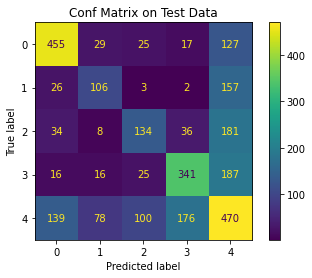

In [9]:
fit_score(XGBClassifier(), CountVectorizer())

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Vectorizer: CountVectorizer(max_features=1000)
Train accuracy: 91.7%
Test accuracy: 76.9%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.80      0.80      0.80       638
           2       0.71      0.66      0.69       304
           3       0.63      0.68      0.65       382
           4       0.8

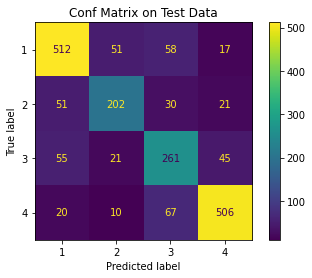

In [14]:
fit_score(XGBClassifier(), CountVectorizer(max_features=1000))

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Vectorizer: TfidfVectorizer()
Train accuracy: 93.1%
Test accuracy: 76.8%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.79      0.79      0.79       638
           2       0.73      0.68      0.70       304
           3       0.64      0.68      0.66       382
           4       0.85      0.84      

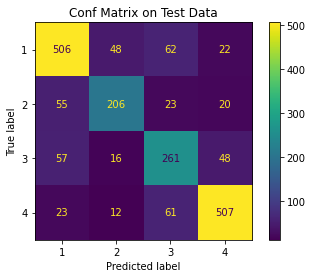

In [27]:
fit_score(XGBClassifier(), TfidfVectorizer())

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Vectorizer: CountVectorizer()
Train accuracy: 70.3%
Test accuracy: 44.0%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.64      0.68      0.66       653
           2       0.09      0.02      0.04       294
           3       0.15      0.06      0.08       393
           4       0.53      0.55      

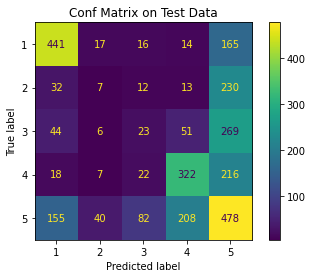

In [11]:
fit_score(XGBClassifier(), CountVectorizer(),lsa =True)

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Vectorizer: TfidfVectorizer()
Train accuracy: 71.5%
Test accuracy: 45.4%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.65      0.70      0.67       653
           2       0.14      0.06      0.09       294
           3       0.25      0.15      0.18       393
           4       0.56      0.62      

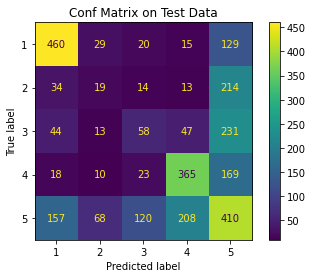

In [12]:
fit_score(XGBClassifier(), TfidfVectorizer(),lsa =True)

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Vectorizer: CountVectorizer(max_df=0.99, min_df=0.01)
Train accuracy: 76.2%
Test accuracy: 50.2%


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       653
           1       0.43      0.35      0.39       294
           2       0.41      0.30      0.34       393
           3   

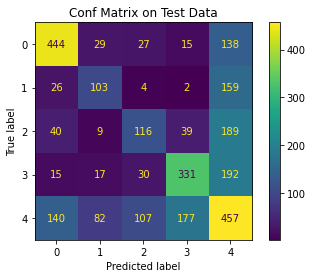

In [10]:
fit_score(XGBClassifier(), CountVectorizer(min_df=0.01,max_df=0.99))

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Vectorizer: CountVectorizer(max_df=0.99, max_features=1000, min_df=0.01)
Train accuracy: 76.2%
Test accuracy: 49.9%


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       653
           1       0.44      0.34      0.38       294
           2       0.41      0.30      0.35       

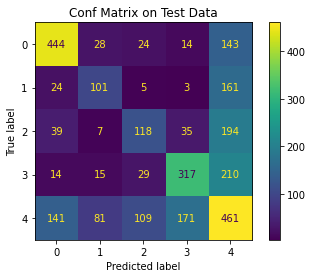

In [11]:
fit_score(XGBClassifier(), CountVectorizer(min_df=0.01,max_df=0.99,max_features=1000))

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Vectorizer: CountVectorizer(max_df=0.99, max_features=1000, min_df=0.01)
Train accuracy: 76.2%
Test accuracy: 49.9%


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       653
           1       0.44      0.34      0.38       294
           2       0.41      0.30      0.35       

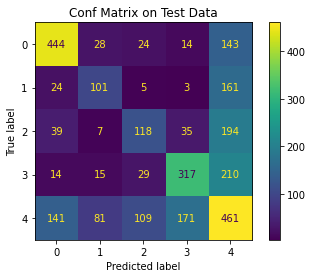

In [12]:
fit_score(XGBClassifier(), CountVectorizer(min_df=0.01,max_df=0.99,max_features=1000))

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Vectorizer: TfidfVectorizer()
Train accuracy: 78.6%
Test accuracy: 50.6%


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       653
           1       0.42      0.33      0.37       294
           2       0.43      0.32      0.36       393
           3       0.59      0.57      

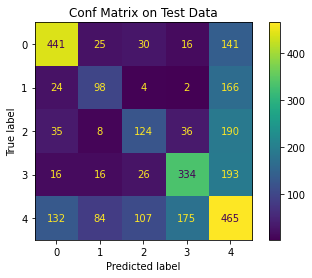

In [17]:
fit_score(XGBClassifier(), TfidfVectorizer())

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Vectorizer: TfidfVectorizer(max_df=0.99, min_df=0.01)
Train accuracy: 78.3%
Test accuracy: 48.1%


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       653
           1       0.39      0.30      0.34       294
           2       0.38      0.27      0.32       393
           3   

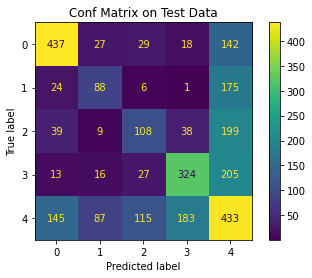

In [14]:
fit_score(XGBClassifier(), TfidfVectorizer(min_df=0.01,max_df=0.99))

### MultinomialNB with TfidfVectorizer

Model: MultinomialNB()
Vectorizer: TfidfVectorizer()
Train accuracy: 59.2%
Test accuracy: 52.3%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.73      0.64      0.68       653
           2       1.00      0.00      0.01       294
           3       0.41      0.02      0.03       393
           4       0.70      0.58      0.64       585
           5       0.41      0.77      0.53       963

    accuracy                           0.52      2888
   macro avg       0.65      0.40      0.38      2888
weighted avg       0.60      0.52      0.47      2888



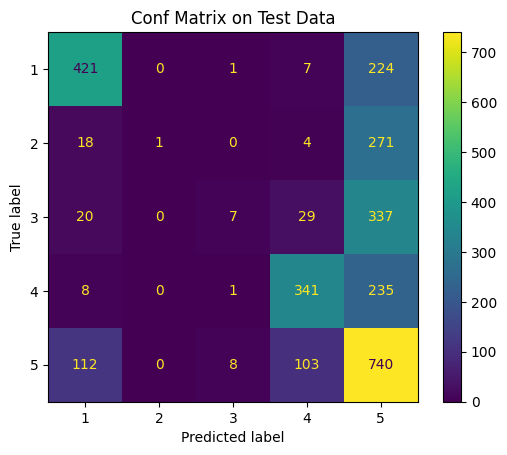

In [36]:
fit_score(MultinomialNB(), TfidfVectorizer())

### DecisionTree with TfidfVectorizer

Model: DecisionTreeClassifier()
Vectorizer: TfidfVectorizer()
Train accuracy: 82.1%
Test accuracy: 42.1%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.57      0.60      0.59       653
           2       0.35      0.35      0.35       294
           3       0.30      0.30      0.30       393
           4       0.51      0.54      0.52       585
           5       0.32      0.29      0.31       963

    accuracy                           0.42      2888
   macro avg       0.41      0.42      0.41      2888
weighted avg       0.42      0.42      0.42      2888



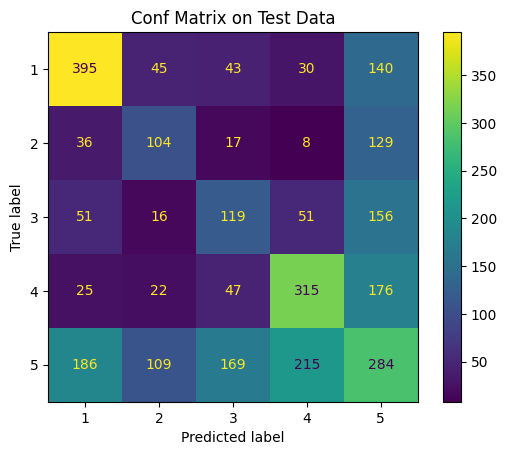

In [37]:
fit_score(DecisionTreeClassifier(), TfidfVectorizer())

### RandomForest with Tfidvectorizer

Model: RandomForestClassifier(n_estimators=10)
Vectorizer: TfidfVectorizer()
Train accuracy: 81.7%
Test accuracy: 42.6%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.60      0.62      0.61       653
           2       0.31      0.22      0.26       294
           3       0.29      0.21      0.24       393
           4       0.52      0.52      0.52       585
           5       0.33      0.39      0.36       963

    accuracy                           0.43      2888
   macro avg       0.41      0.39      0.40      2888
weighted avg       0.42      0.43      0.42      2888



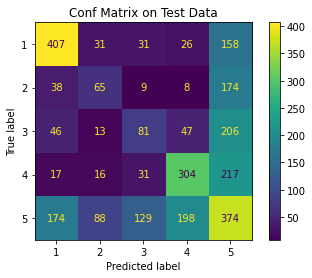

In [6]:
fit_score(RandomForestClassifier(n_estimators =10),TfidfVectorizer())

Model: RandomForestClassifier(n_estimators=50)
Vectorizer: TfidfVectorizer()
Train accuracy: 82.1%
Test accuracy: 46.3%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.65      0.66      0.66       653
           2       0.35      0.24      0.29       294
           3       0.32      0.21      0.25       393
           4       0.55      0.58      0.56       585
           5       0.36      0.43      0.39       963

    accuracy                           0.46      2888
   macro avg       0.44      0.42      0.43      2888
weighted avg       0.46      0.46      0.46      2888



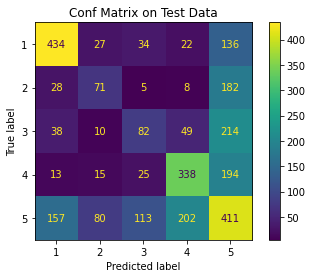

In [7]:
fit_score(RandomForestClassifier(n_estimators =50),TfidfVectorizer())

Model: GradientBoostingClassifier()
Vectorizer: TfidfVectorizer()
Train accuracy: 67.3%
Test accuracy: 56.6%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.70      0.73      0.71       653
           2       0.52      0.35      0.42       294
           3       0.53      0.31      0.39       393
           4       0.68      0.63      0.65       585
           5       0.46      0.59      0.52       963

    accuracy                           0.57      2888
   macro avg       0.58      0.52      0.54      2888
weighted avg       0.57      0.57      0.56      2888



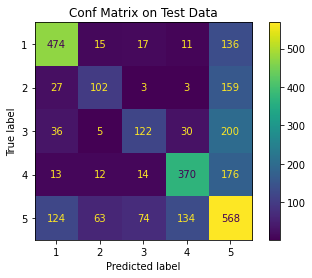

In [13]:
fit_score(GradientBoostingClassifier(), TfidfVectorizer())

### DecisionTree with HashingVectorizer

Model: DecisionTreeClassifier()
Vectorizer: HashingVectorizer()
Train accuracy: 82.1%
Test accuracy: 42.9%


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.57      0.61      0.59       653
           2       0.36      0.38      0.37       294
           3       0.32      0.32      0.32       393
           4       0.50      0.52      0.51       585
           5       0.34      0.31      0.32       963

    accuracy                           0.43      2888
   macro avg       0.42      0.43      0.42      2888
weighted avg       0.42      0.43      0.43      2888



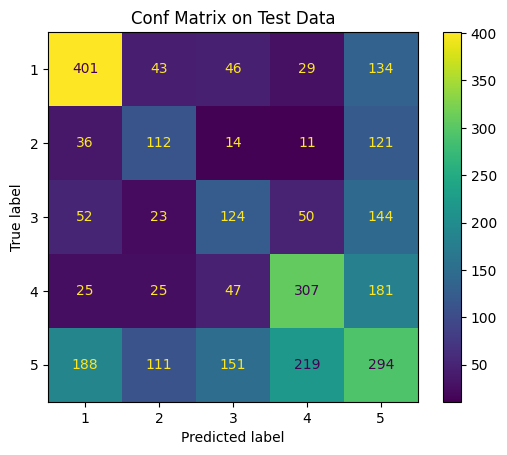

In [39]:
fit_score(DecisionTreeClassifier(), HashingVectorizer())

- Best simple model was __MultinomialNB, CountVectorizer__ with a 59.5% test acc